In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

__Подготовка данных__

In [5]:
df = pd.read_csv('traffic_moscow.csv', header=None)
df.columns = ["i", "j", "amt", "t", "s"]

In [6]:
def make_index(i, j):
    residents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    if int(i) in residents:
        return 1 # живут в Москве
    else:
        return 0 # живут в области

df['r'] = df.apply(lambda row: make_index(row['i'], 
        row['j']), axis=1) # добавили столбец принадлежности москвичам

def amt_for_residents(df): # умножили значения москвичей на 1.62
    for i in range(df.shape[0]):
        df.loc[i, 'amt'] *= 1.62 if df.loc[i, 'r'] == 1 else 1
    return df

df = amt_for_residents(df)

In [7]:
df.head()

,i,j,amt,t,s,r
0,1,1,64.80,26,2.2,1
1,1,2,6.48,49,8.1,1
2,1,3,4.86,35,6.8,1
3,1,4,3.24,75,9.3,1
4,1,5,3.24,30,8.0,1


__Инициализируем матрицу издержек T, матрицу d, L и W__

In [11]:
def costs_func(i, j, column):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    c = columns[column]
    try:
        c = int(c)
        return c
    except TypeError: # если не пересекается район i с районом j
        return 0
    
def f_T(T, alpha):
    return np.exp(alpha * T)

def create_T_d():
    T = np.zeros((22, 22))
    d = np.zeros((22, 22))
    for i in range(0, 22):
        for j in range(0, 22):
            T[i][j] = costs_func(i, j, 't')
            d[i][j] = costs_func(i, j, 'amt')
    return T, d

In [12]:
L_i = df.groupby('i')['amt'].sum().reset_index()
W_j = df.groupby('j')['amt'].sum().reset_index()

W = W_j.as_matrix()[:, [1]]
L = L_i.as_matrix()[:, [1]]    
    
total_i = L_i['amt'].sum()
total_j = W_j['amt'].sum()

print(total_i, total_j) # проверили что правильно нашли L и W

T, d = create_T_d()

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


2571.36 2571.3599999999997


__Просто Синхорн, но теперь через $\lambda$, а не A и B__

__Важно!!!__ Необходимо отнормировать матрицы L и W

In [38]:
def Sinkhorn(k, beta, alpha, lambda_W_prev, lambda_L_prev):
    summa = 0
    
    lambda_L = np.zeros((n, ), dtype=float)
    lambda_W = np.zeros((n, ), dtype=float)
    
    if k % 2 == 0:
        for i in range(n):
            for j in range(n):
                summa += ( np.exp(-lambda_W_prev[j]) / 
                            L[i] * np.exp(1 + beta * alpha * T[i][j]) )
            lambda_L[i] = np.log(summa)
            summa = 0
        lambda_W = lambda_W_prev
    else:
        for j in range(n):
            for i in range(n):
                summa += ( np.exp(-lambda_L_prev[i]) / 
                            W[j] * np.exp(1 + beta * alpha * T[i][j]) )
            lambda_W[j] = np.log(summa)
            summa = 0
        lambda_L = lambda_L_prev
    return lambda_W, lambda_L

def iterate(beta, alpha, d, L, W, num_iter, eps):
    
    lambda_L = np.zeros((n, ), dtype=float)
    lambda_W = np.zeros((n, ), dtype=float)
    
    for k in range(num_iter):
        
        lambda_Wn, lambda_Ln = Sinkhorn(k, beta, alpha, lambda_W, lambda_L)
        
        delta = np.linalg.norm(np.concatenate((lambda_Ln - lambda_L, lambda_Wn - lambda_W)))
        
        if delta < eps:
            break
            
        lambda_L, lambda_W = lambda_Ln, lambda_Wn 
    
    r = error_d_i_j(lambda_Ln, lambda_Wn, d, beta, alpha)
    
    return r

def error_d_i_j(lambda_L, lambda_W, d, beta, alpha):
    return np.exp( -1 - T - (np.reshape(lambda_L, (22, 1)) + lambda_W) ) #* people_num 

__Смотрим лямбды__

In [39]:
num_iter = 2500
alpha, beta = 1.0, 1.0
n = 22

L_i = df.groupby('i')['amt'].sum().reset_index()
W_j = df.groupby('j')['amt'].sum().reset_index()

W = W_j.as_matrix()[:, 1]
L = L_i.as_matrix()[:, 1]

people_num = np.sum(W)

W = W / np.sum(W)
L = L / np.sum(L)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [40]:
num_iter = 1500
alpha = 1.0
beta_range = np.arange(0.0, 0.02, 0.0005)
res_list = []
for beta in beta_range:
    rec = iterate(beta, alpha, d, L, W, num_iter, eps=0.01) * people_num
    res_list.append(np.linalg.norm(d - rec))

In [41]:
np.min(res_list), res_list.index(np.min(res_list)), beta_range[res_list.index(np.min(res_list))]

(342.62569661721324, 19, 0.0095)

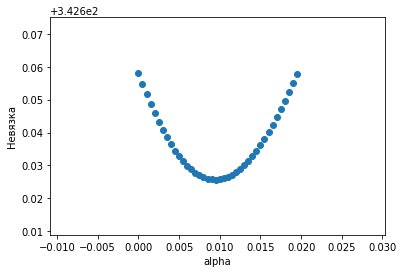

In [42]:
plt.scatter(beta_range, res_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

In [16]:
num_iter = 1500
alpha = 1.0
beta_range = np.arange(0.0, 0.1, 0.001)
res_list = []
for beta in beta_range:
    rec = iterate(beta, alpha, d, L, W, num_iter, eps=0.01) * people_num
    res_list.append(np.linalg.norm(d - rec))
#     print(np.linalg.norm(d - rec), beta)

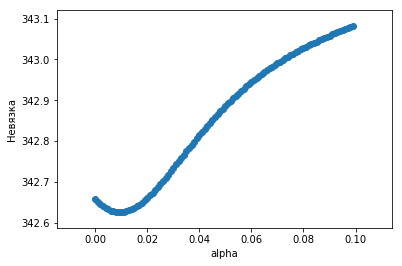

In [17]:
plt.scatter(beta_range, res_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()